In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import dtw

from data_processing import DataIterator
from models import Autoregression

# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [2]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0, nrows=120000)

## Формат данных
Данные представляют собой зависимость потенциалов в 128 точках мозга обезъяны от времени.   
Показатели снимаются каждую миллисекунду.  

Всего - 3697432 измерений

In [3]:
data_sample = data.loc[100000:100700, :"ECoG_ch6"]

In [4]:
data_sample.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
100000,100.000,51,111,-101,107,-18,118
100001,100.001,63,118,-101,115,13,166
100002,100.002,62,137,-87,143,21,167
100003,100.003,65,146,-61,124,16,201
100004,100.004,94,167,-57,109,89,268


## Визуализация данных
Данные взяты из середины выборки

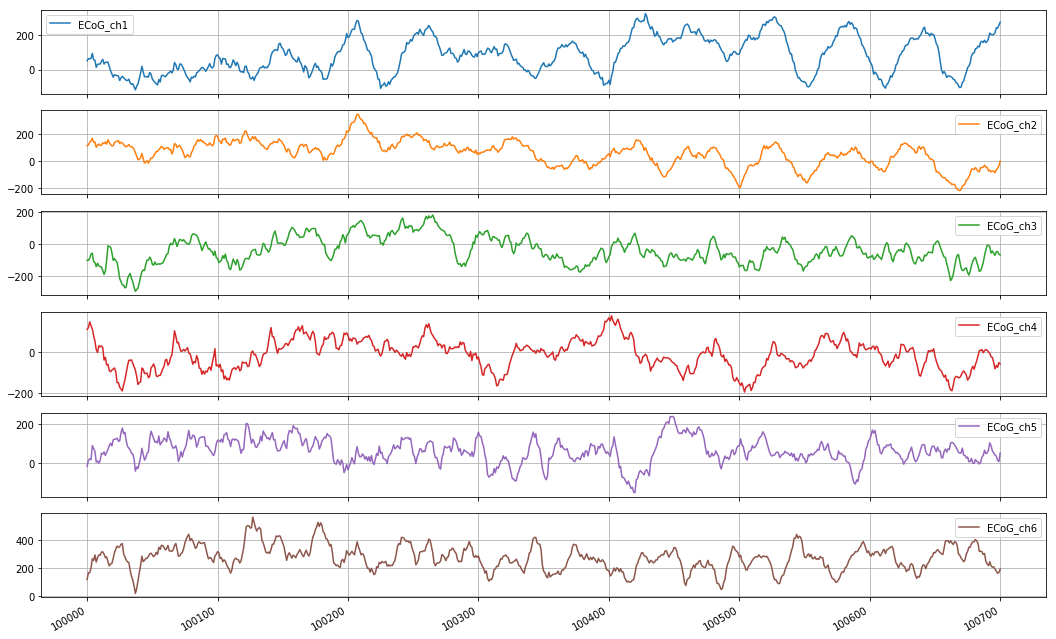

In [5]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 12), grid=True);

## Проведем серию усреднений, чтобы посмотреть на тенденции измерения потенциалов
### Небольшое усреднение по трем, рядом лежащим, точкам

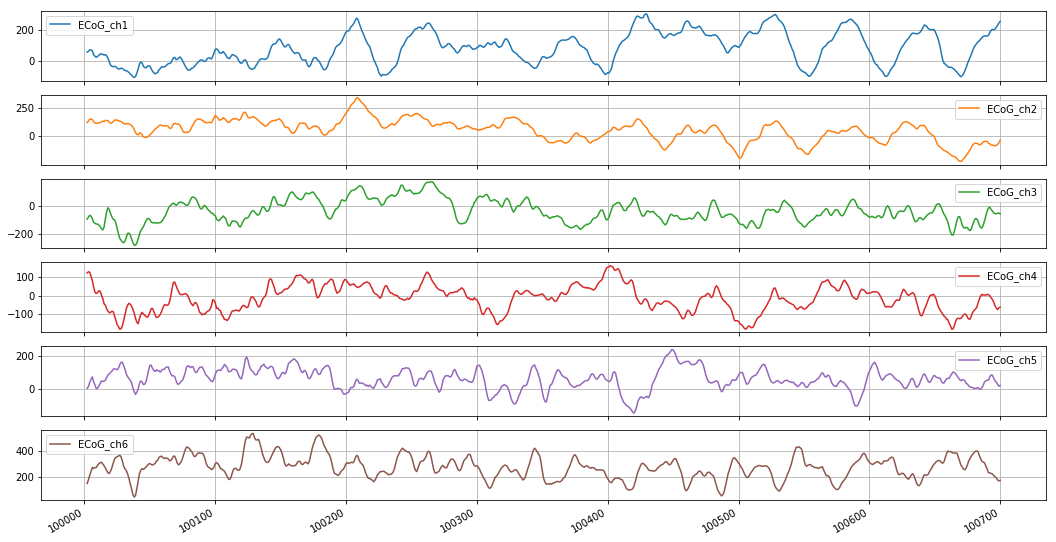

In [6]:
%matplotlib inline
data_sample.rolling(window=3).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Усреднение по 20 точкам

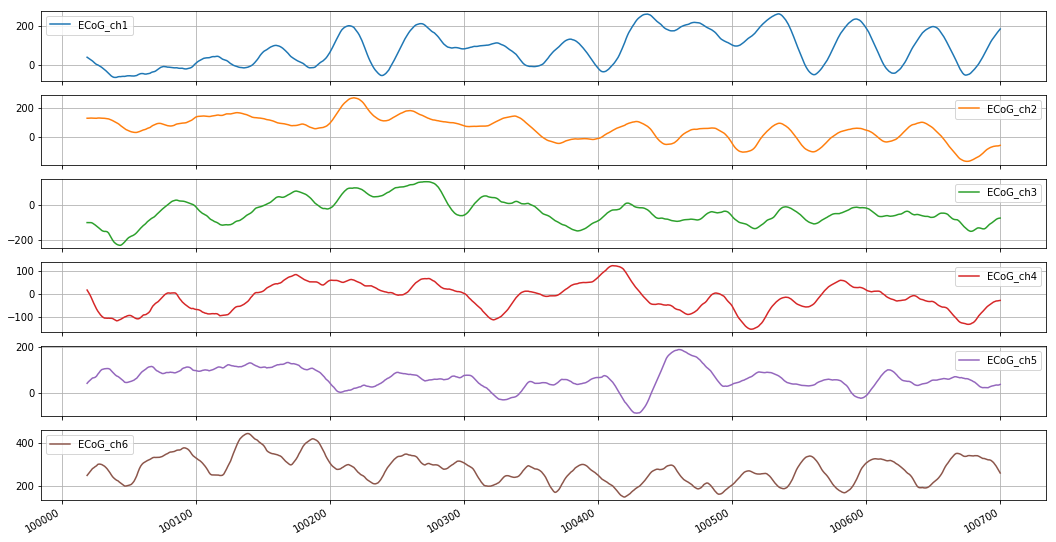

In [7]:
%matplotlib inline
data_sample.rolling(window=20).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Посмотрим на маленький отрезок данных

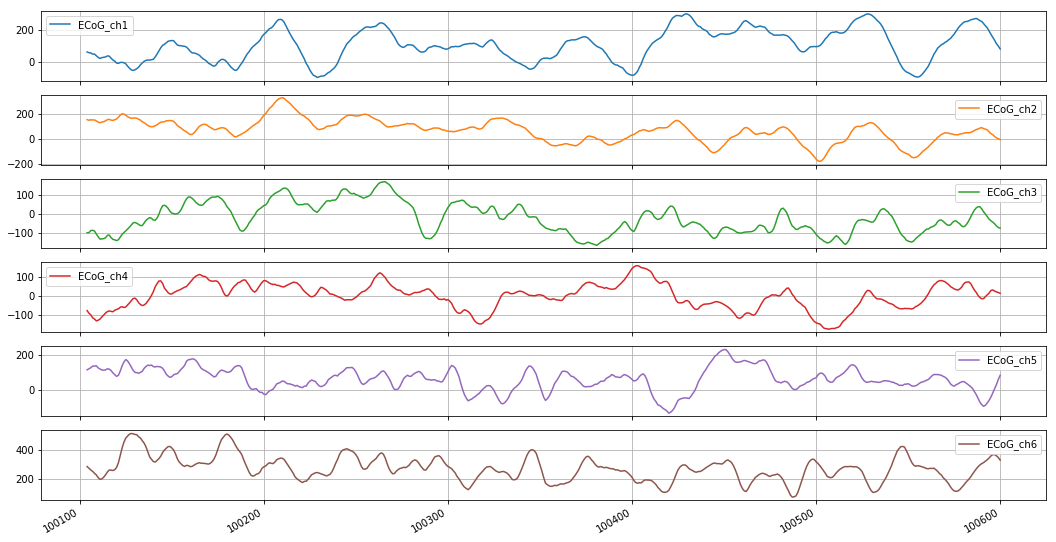

In [8]:
%matplotlib inline
data_sample.loc[100100:100600, "ECoG_ch1":].rolling(window=5).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Для большего количества измерений

In [9]:
data_sample = data.loc[:100000, :"ECoG_ch6"]

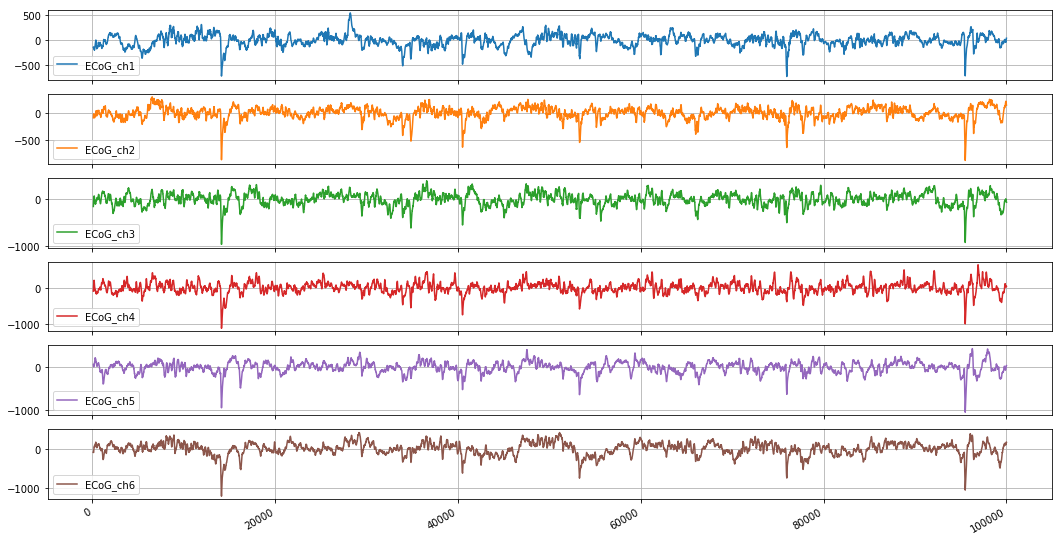

In [10]:
%matplotlib inline
data_sample.rolling(window=100).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Предположение
Можно попробовать два варианта разбиения временных рядом по 100 и по 300 точек.  
Так как в среднем, за этот период ряд претерпевает изменение значений в обе стороны.

In [11]:
#  Итератор для данных, ряды переманны
element_length = 100
data_iter = DataIterator(data_sample, element_length)

In [12]:
item = next(data_iter)

In [13]:
item.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
53600,53.600,-16,-10,278,112,-144,-367
53601,53.601,-23,-11,289,137,-171,-367
53602,53.602,-35,-19,257,127,-213,-387
53603,53.603,-25,-6,237,118,-234,-404
53604,53.604,-5,16,244,103,-240,-398


## Эксперимент с DTW для первого измерения

In [14]:
x = next(data_iter).loc[:, "ECoG_ch1"]
y = next(data_iter).loc[:, "ECoG_ch1"]

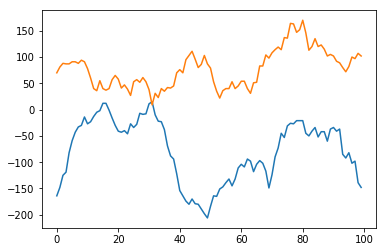

In [15]:
%matplotlib inline
time = np.linspace(0, element_length - 1, element_length)
plt.plot(time, x)
plt.plot(time, y)

In [16]:
def one_dimension_dtw(x, y):
    return dtw.dtw(x.values.reshape(-1, 1), y.values.reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [17]:
dist, cost, acc, path = one_dimension_dtw(x, y)

Distance: 77.600


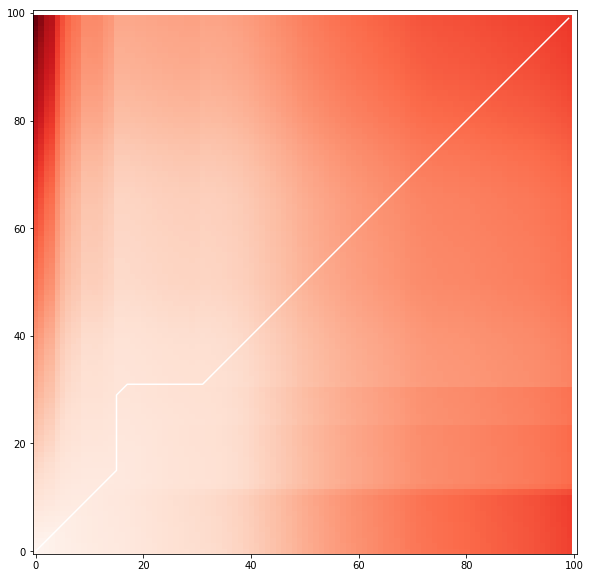

In [18]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

# Эксперимент с авторегрессионной моделью

In [19]:
import torch

In [20]:
window_size = 10
ar = Autoregression(item.loc[:, :"ECoG_ch5"], window_size)

In [21]:
ar.fit(10)

Loss: 102451.125
Loss: 5367.944
Loss: 5323.977
Loss: 5297.216
Loss: 5276.738
Loss: 5260.816
Loss: 5248.351
Loss: 5238.531
Loss: 5230.753
Loss: 5224.552
Loss: 5219.581
Loss: 5215.573
Loss: 5212.326
Loss: 5209.681
Loss: 5207.515


In [22]:
predicted = ar.predicted_series
x = ar.data.loc[:, "ECoG_ch1" : "ECoG_ch5"].values

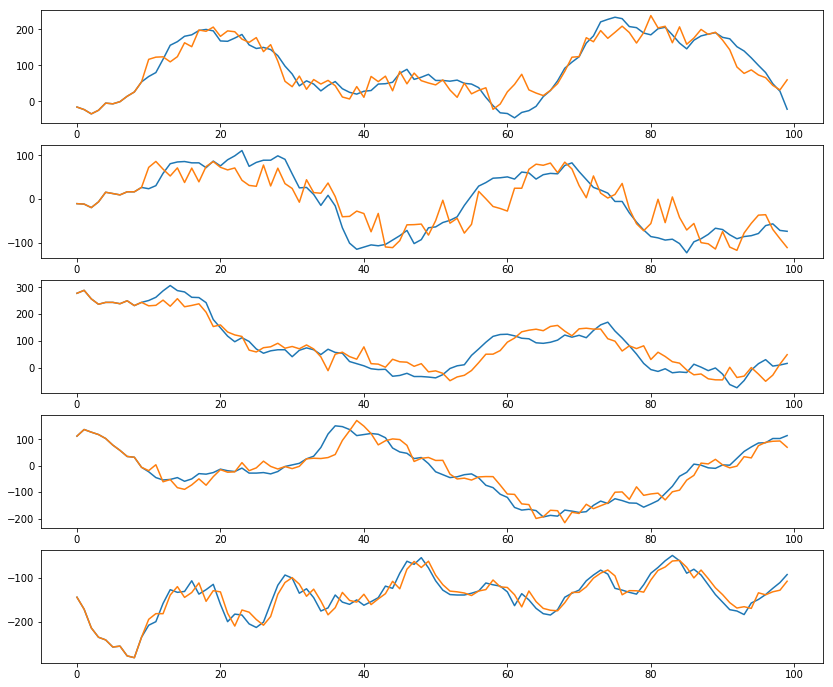

In [23]:
plt.figure(figsize=(14, 12))
time = np.linspace(0, element_length - 1, element_length)

for (i, pred) in enumerate(predicted):
    
    plt.subplot(len(predicted), 1, i+1)
    plt.plot(time, x[:,i])
    plt.plot(time, pred)

plt.show()